**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
print("Aboba")

Aboba


# Setup

In [189]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import seaborn as sns, pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Fashion MNIST Classifier



## Data

In [2]:
X = dict()
y = dict()

(X['train'], y['train']), (X['test'], y['test']) = keras.datasets.fashion_mnist.load_data()
X['train'], X['test'] = (X.astype('float32')/255 for X in (X['train'], X['test']))


4431872/4422102 [==============================] - 0s 0us/step


In [3]:
print(f"""
X shape:{X['test'].shape[1:]}
y shape: 1
Dtype: {X['test'].dtype}
{'-'*54}""")

for split in X.keys():
    print(f"""{split.capitalize()}: {y[split].shape[0]}""")


X shape:(28, 28)
y shape: 1
Dtype: float32
------------------------------------------------------
Train: 60000
Test: 10000


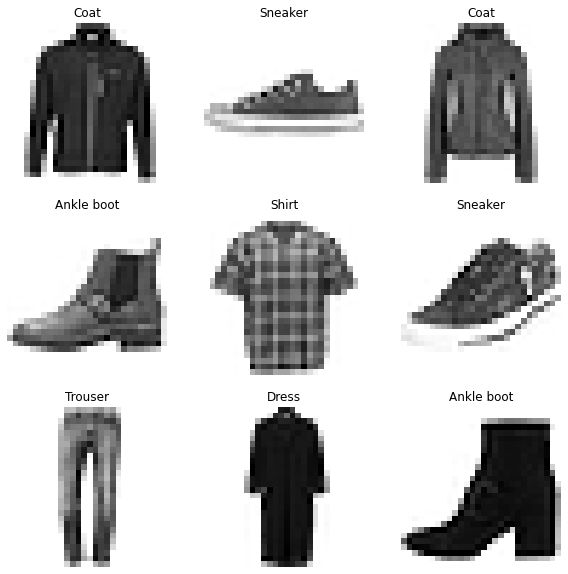

In [182]:
n_cols, n_rows = 3,3
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
n_classes = len(class_names)

def plot_random_items(n_cols = 3, n_rows = 3, cmap = 'binary', model=None, split = 'train'):
    figure = plt.figure(figsize=(10, 10))
    for i in range(1, n_cols * n_rows + 1):
        sample_idx = np.random.randint(X[split].shape[0],size=(1,))[0]
        figure.add_subplot(n_rows, n_cols, i)
        _title = class_names[y[split][sample_idx]] if model is None \
        else f'''
        True:{class_names[y[split][sample_idx]]}
        Pred: {class_names[
                           np.argmax(model.predict(np.expand_dims(X[split][sample_idx],axis=0)),axis=-1)[0]]}'''
        plt.title(_title)
        plt.axis("off")
        plt.imshow(X[split][sample_idx], cmap=cmap, interpolation='nearest')
    plt.show()

plot_random_items(split = 'train')

## Model

In [6]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=X['test'].shape[1:]),
    keras.layers.Dense(350, activation = 'relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(n_classes, activation='softmax')]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 350)               274750    
                                                                 
 dropout (Dropout)           (None, 350)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               35100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 310,860
Trainable params: 310,860
Non-trainable params: 0
_________________________________________________________________


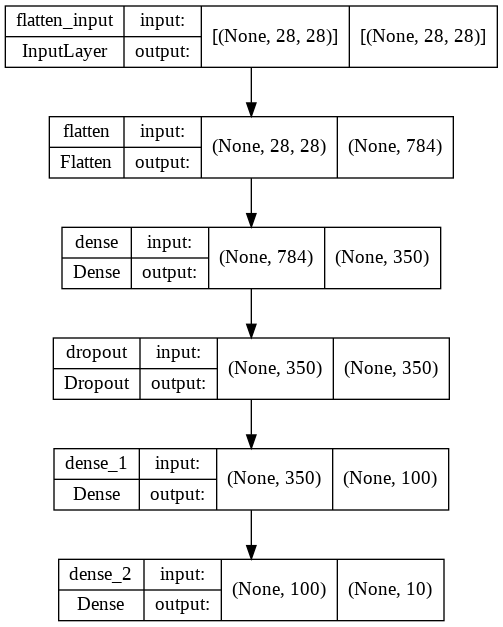

In [8]:
plot_model(model,show_shapes=True,show_dtype=not True)

In [7]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [ ]:
history = model.fit(X['train'],y['train'],
          validation_split = 0.7,
          epochs = 30,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=3)])

In [144]:

fig = make_subplots(
                    rows=1,cols=2,
                    subplot_titles=['Accuracy graph'*0,'Loss graph'*0]
                    )

fig.append_trace(go.Scatter(
                         y=history.history['accuracy'],
                         name='train accuracy',
                         mode='lines+markers',
                         legendgroup = 1),
              row=1,col=1)
fig.append_trace(go.Scatter(
                         y=history.history['val_accuracy'],
                         name='val accuracy',
                         mode='lines+markers',
                         legendgroup = 1),
              row=1,col=1)

fig.append_trace(go.Scatter(
                         y=history.history['loss'],
                         name='train loss',
                         mode='lines+markers',
                         legendgroup=2),
              row=1,col=2)
fig.append_trace(go.Scatter(
                         y=history.history['val_loss'],
                         name='val loss',
                         mode='lines+markers',
                         legendgroup=2),
              row=1,col=2)

fig.update_xaxes(title_text='Epoch')
fig.update_yaxes(title_text='Accuracy',row=1,col=1)
fig.update_yaxes(title_text='Loss',row=1,col=2)
fig.update_layout(legend = {'orientation':'h',
                            'xanchor':'left',
                            'yanchor':'top',
                            'x':0,
                            'y':1.2},)

In [9]:
weights, biases = model.layers[1].get_weights()
print(f"""Fully Connected[1]:
weights shape: {weights.shape}
biases shape: {biases.shape}
""")

Fully Connected[1]:
weights shape: (784, 350)
biases shape: (350,)



In [91]:
model.evaluate(X['test'],y['test'])

313/313 [==============================] - 1s 4ms/step - loss: 0.3698 - accuracy: 0.8737
[0.36975473165512085, 0.8737000226974487]


In [167]:
k = 2
X_new = np.expand_dims(X['test'][k],axis=0)
print(X_new.shape)
predictions = np.argmax(model.predict(X_new),axis=-1)
for i in range(1):
    print(f"""Predicted label: {class_names[predictions[i]]}
    Actual label: {class_names[y['test'][k]]}""")

(1, 28, 28)
Predicted label: Trouser
    Actual label: Trouser


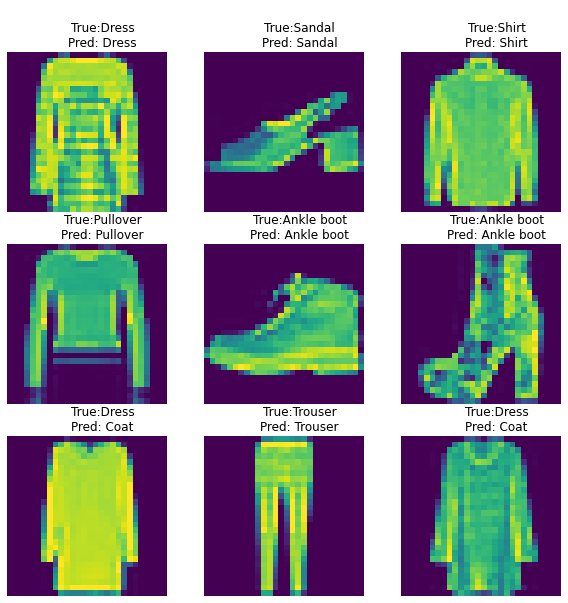

In [187]:
plot_random_items(split = 'test', model = model, cmap='viridis')

# Housing Regression

## Data

In [191]:
housing = fetch_california_housing()
housing.data.shape

(20640, 8)

In [210]:
X['train'], X['test'], y['train'], y['test'] = train_test_split(housing['data'], housing['target'], test_size=0.3, shuffle=True)
X['train'].shape[0], X['test'].shape[0]

(14448, 6192)

In [201]:
print(housing['frame'])

[[   8.3252       41.            6.98412698 ...    2.55555556
    37.88       -122.23      ]
 [   8.3014       21.            6.23813708 ...    2.10984183
    37.86       -122.22      ]
 [   7.2574       52.            8.28813559 ...    2.80225989
    37.85       -122.24      ]
 ...
 [   1.7          17.            5.20554273 ...    2.3256351
    39.43       -121.22      ]
 [   1.8672       18.            5.32951289 ...    2.12320917
    39.43       -121.32      ]
 [   2.3886       16.            5.25471698 ...    2.61698113
    39.37       -121.24      ]]


In [215]:
scaler = StandardScaler()
X['train'] = scaler.fit_transform(X['train'])
X['test'] = scaler.transform(X['test'])

## Model

In [243]:
n_features = housing['data'].shape[1:]
model = keras.models.Sequential([
                                 keras.layers.Dense(50,input_shape=n_features, activation='relu'),
                                 keras.layers.Dropout(.2),
                                 keras.layers.Dense(25,input_shape=n_features, activation='relu'),
                                 keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=1e-3))
#plot_model(model,show_shapes=True)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                450       
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 25)                1275      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,751
Trainable params: 1,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X['train'],y['train'],
          validation_split = 0.7,
          epochs = 100,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=10)])

In [ ]:
def plot_regr_loss(history):
    fig = make_subplots(
                        rows=1,cols=1,
                        subplot_titles=['Loss']
                        )
    x_s = np.arange(1, len(history.history['loss']) + 1)

    fig.append_trace(go.Scatter(
                            x = x_s,
                            y=history.history['loss'],
                            name='train',
                            mode='lines+markers'), row=1,col=1)
    fig.add_trace(go.Scatter(
                            x = x_s,
                            y=history.history['val_loss'],
                            name='val',
                            mode='lines+markers'), row=1,col=1)

    fig.update_xaxes(title_text='Epoch')
    fig.update_yaxes(title_text='Loss',row=1,col=1)
    # fig.update_layout(legend = {'orientation':'h',
    #                             'xanchor':'left',
    #                             'yanchor':'top',
    #                             'x':0,
    #                             'y':1.2},)
    return fig

plot_regr_loss(history)

In [248]:
model.evaluate(X['train'],batch_size=16)

903/903 [==============================] - 2s 2ms/step - loss: 0.0000e+00


0.0

## Regression with Functional API

# <h3>Wide & Deep</h3>

In [262]:
num_hiddens = 3
input_layer = keras.layers.Input(shape=X['train'].shape[1:])
hidden_layer = keras.layers.Dense(30,activation='relu')(input_layer)

for i in range(1, num_hiddens):
    hidden_layer = keras.layers.Dense(30,activation='relu')(hidden_layer)
    hidden_layer = keras.layers.Dropout(0.2)(hidden_layer)

output_layer = keras.layers.Dense(1)(
    keras.layers.concatenate([input_layer, hidden_layer])
)

model = keras.models.Model(inputs=[input_layer],
                           outputs=[output_layer])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 dense_46 (Dense)               (None, 30)           270         ['input_12[0][0]']               
                                                                                                  
 dense_47 (Dense)               (None, 30)           930         ['dense_46[0][0]']               
                                                                                                  
 dropout_4 (Dropout)            (None, 30)           0           ['dense_47[0][0]']               
                                                                                            

In [ ]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3))

history = model.fit(X['train'],y['train'],
          validation_split = 0.3,
          epochs = 100,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=10)])

In [272]:
plot_regr_loss(history)

# <h3>Wide & Deep with 2 inputs, 2 outputs</h3>

In [ ]:
num_hiddens = 4

wide_input_layer = keras.layers.Input(shape = [5], name = 'wide_input') # 5 - for example
deep_input_layer = keras.layers.Input(shape=[6], name = 'deep_input')

hidden_layer = keras.layers.Dense(30, activation = 'relu', name = f'hidden_1')(deep_input_layer)

for i in range(1, num_hiddens):
    hidden_layer = keras.layers.Dense(30, activation='relu', name = f'hidden_{i+1}')(hidden_layer)
    hidden_layer = keras.layers.Dropout(0.2, name = f'dropout_{i}')(hidden_layer)

concat_layer = keras.layers.concatenate([wide_input_layer,deep_input_layer,hidden_layer])
output_layers = keras.layers.Dense(1, name = 'main_output')(concat_layer), keras.layers.Dense(1, name = 'auxiliary_output')(hidden_layer)

model = keras.models.Model(inputs = [wide_input_layer, deep_input_layer],
                           outputs = output_layers)

model.compile(loss=['mae','mse'],
              loss_weights = [0.5,0.6],
              optimizer = keras.optimizers.Adam(learning_rate=1e-3))

plot_model(model, show_shapes = True)

In [294]:
X['test'][:1,-6:]

array([[ 0.86386732, -0.19076355,  0.54835782,  0.04789818, -0.86984743,
         0.87705504]])

In [316]:
history = model.fit(
    [X['train'][:,:5], X['train'][:,-6:]],
    [y['train'], y['train']],
    validation_split = 0.3,
    epochs = 100,
    batch_size = 64,
    callbacks = [tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=10)])

Epoch 1/100
159/159 [==============================] - 1s 5ms/step - loss: 0.4911 - main_output_loss: 0.4219 - auxiliary_output_loss: 0.4669 - val_loss: 0.4338 - val_main_output_loss: 0.4008 - val_auxiliary_output_loss: 0.3890
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.4848 - main_output_loss: 0.4207 - auxiliary_output_loss: 0.4574 - val_loss: 0.4524 - val_main_output_loss: 0.4099 - val_auxiliary_output_loss: 0.4125
Epoch 3/100
159/159 [==============================] - 1s 6ms/step - loss: 0.4902 - main_output_loss: 0.4232 - auxiliary_output_loss: 0.4644 - val_loss: 0.4187 - val_main_output_loss: 0.3958 - val_auxiliary_output_loss: 0.3680
Epoch 4/100
159/159 [==============================] - 2s 10ms/step - loss: 0.4799 - main_output_loss: 0.4173 - auxiliary_output_loss: 0.4521 - val_loss: 0.4355 - val_main_output_loss: 0.4001 - val_auxiliary_output_loss: 0.3924
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.4853 - main_ou

In [317]:
plot_regr_loss(history)